In [1]:
from battery.battery import Battery
from price_modelling.price_path_generator import IDPriceSimulator
from price_modelling.global_keys import *
from optimization.rolling_intrinsic import RollingIntrinsicStrategy
import pandas as pd
import yaml
import numpy as np

Tune ID price simulator to ID VWAP and DA auction data

In [2]:
df_all_VWAP_data_DA = pd.read_csv("../data/all_VWAP_DA_data.csv", sep=";")
# set columns to datetime type
df_all_VWAP_data_DA["delivery_start"] = pd.to_datetime(df_all_VWAP_data_DA["delivery_start"])
df_all_VWAP_data_DA["delivery_start_hour"] = pd.to_datetime(df_all_VWAP_data_DA["delivery_start_hour"])
df_all_VWAP_data_DA["traded"] = pd.to_datetime(df_all_VWAP_data_DA["traded"])

price_generator_DA = IDPriceSimulator()
price_generator_DA.fit_model(df_all_VWAP_data_DA)

In [3]:
price_generator_DA.param_plot("spring")

c:\Users\cah30\repos\Thesis\battery_intraday_optimizer\src\price_modelling\price_path_generator.py:191: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



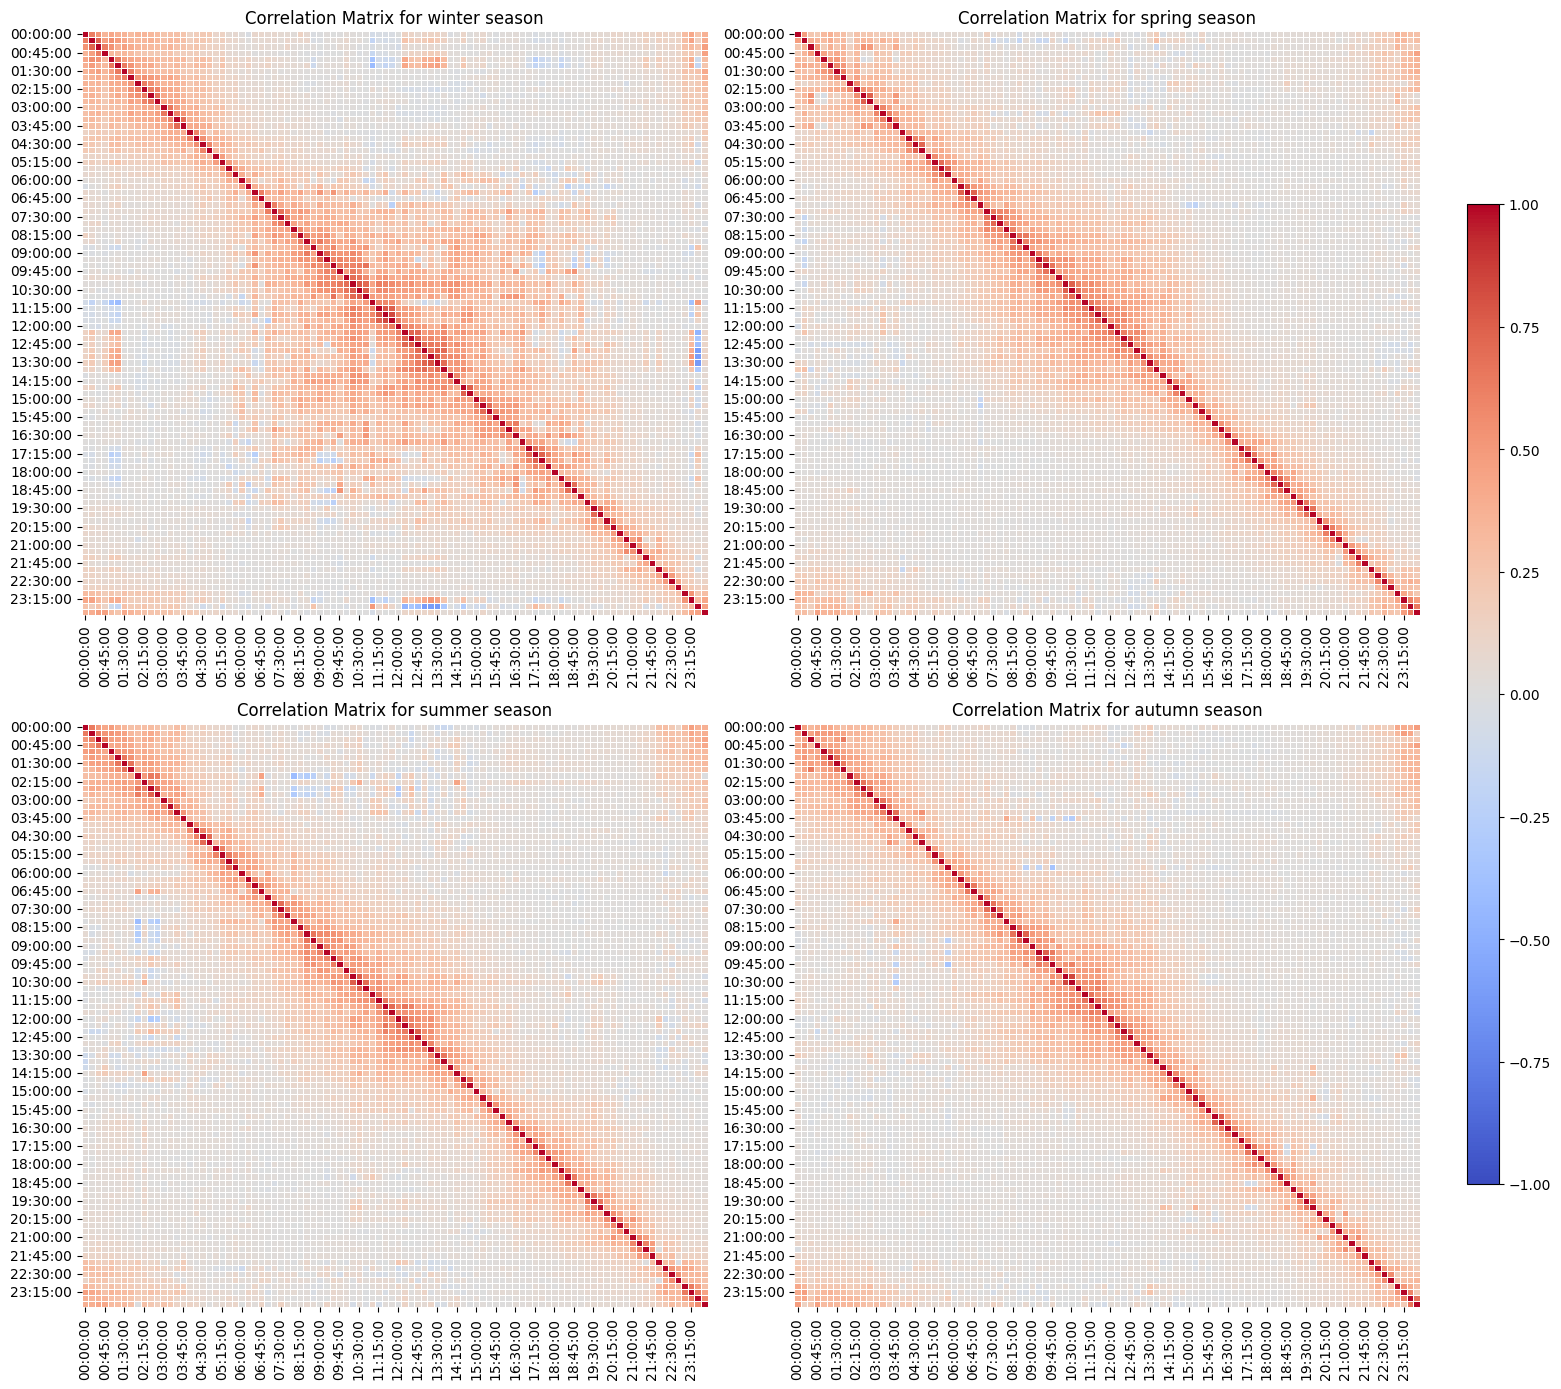

In [4]:
price_generator_DA.cor_heatmaps()

Tune ID price simulator to ID VWAP and ID1 auction data

In [5]:
df_all_VWAP_data_ID1 = pd.read_csv("../data/all_VWAP_ID1_data.csv", sep=";")
# set columns to datetime type
df_all_VWAP_data_ID1["delivery_start"] = pd.to_datetime(df_all_VWAP_data_ID1["delivery_start"])
df_all_VWAP_data_ID1["delivery_start_hour"] = pd.to_datetime(df_all_VWAP_data_ID1["delivery_start_hour"])
df_all_VWAP_data_ID1["traded"] = pd.to_datetime(df_all_VWAP_data_ID1["traded"])

price_generator_ID1 = IDPriceSimulator()
price_generator_ID1.fit_model(df_all_VWAP_data_ID1)

c:\Users\cah30\repos\Thesis\battery_intraday_optimizer\src\price_modelling\price_path_generator.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\cah30\repos\Thesis\battery_intraday_optimizer\src\price_modelling\price_path_generator.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\cah30\repos\Thesis\battery_intraday_optimizer\src\price_modelling\price_path_generator.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [6]:
price_generator_ID1.param_plot("spring")

In [7]:
price_generator_DA.cor_heatmaps

<bound method IDPriceSimulator.cor_heatmaps of <price_modelling.price_path_generator.IDPriceSimulator object at 0x000002332CEE22D0>>

Setup Battery

In [14]:
# read config.yml
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)  

battery = Battery(config)

Create test price path array

In [15]:
price_path_array, P = price_generator_DA.generate_price_paths(season="spring", N_paths=1)
price_path = price_path_array[0, :, :]

In [16]:
# price_path_array = np.ones((1,config["N_trading_timesteps"],config["N_timesteps"]))

# price_path_array[0,0,1:4] = 5
# price_path_array[0,0,26:29] = 0

# price_path_array[0,1,4:7] = -10
# price_path_array[0,1,23:26] = 2

# price_path_array[0,4,10:15] = -30
# # price_path_array[0,4,26:29] = 0

# # price_path_array[0,4,4:7] = -10
# # price_path_array[0,4,23:26] = 2





In [17]:
intrinsic_strategy = RollingIntrinsicStrategy(battery, price_path, config)

In [18]:
power_schedules, soc_schedules, price_path, results = intrinsic_strategy.run()

In [21]:
eps = 1e-8

# Test if schedules are within bounds
for power_schedule in power_schedules:
    assert np.all(np.abs(power_schedule) <= battery.capacity)

for soc_schedule in soc_schedules:
    assert np.all(soc_schedule >= -eps) and np.all(soc_schedule <= 1+eps)

# Test if results are equal to power_schedule multiplied by price_path
for t in range(2, len(results) - 1):
    # print(t)
    assert np.abs(results[t]-results[t-1] - np.sum((power_schedules[t] - power_schedules[t-1]) * price_path[t,:])) < eps

# Test if the number of cycles is less than the maximum allowed
# assert np.sum(np.abs(power_schedules[-1]))/2 * battery.RTE <= battery.N_daily_cycles_max
# # Lower bound on revenues
# costs = np.sum(power_schedules * price_path[0,:,:], axis=1)
# # assert np.all(costs >= 0)
# costs

In [23]:
# plot schedule 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

timestep = -1
# Add SOC schedule trace on primary y-axis
fig.add_trace(
    go.Scatter(
        x=list(range(len(soc_schedules[0]))),
        y=soc_schedules[timestep],
        name="SOC",
        line=dict(color="#00BFFF"),  # Bright blue for better visibility on dark theme
        mode="lines",
        line_shape="hv"
    ),
    secondary_y=False
)

# Add price path trace on secondary y-axis
fig.add_trace(
    go.Scatter(
        x=list(range(len(price_path[timestep,:]))),
        y=price_path[timestep,:],
        name="Price",
        line=dict(color="#FF5733"),  # Bright orange-red for better visibility
        mode="lines",
        line_shape="hv"
    ),
    secondary_y=True
)

# Set titles and labels with dark theme
fig.update_layout(
    title_text="Battery State of Charge and Price Path",
    hovermode="x unified",
    template="plotly_dark",  # Use dark template
    paper_bgcolor="rgb(30, 30, 30)",  # Dark background color
    plot_bgcolor="rgb(30, 30, 30)",
    font=dict(color="white")  # White text
)
fig.update_xaxes(title_text="Time Step", gridcolor="rgba(255, 255, 255, 0.2)")
fig.update_yaxes(title_text="State of Charge (SOC)", secondary_y=False, gridcolor="rgba(255, 255, 255, 0.2)")
fig.update_yaxes(title_text="Price", secondary_y=True, gridcolor="rgba(255, 255, 255, 0.2)")

# Show the interactive plot
fig.show()

In [25]:

fig = make_subplots()

# Add SOC schedule trace on primary y-axis
fig.add_trace(
    go.Scatter(
        x=list(range(len(results))),
        y=results,
        name="Revenues [€]",
        line=dict(color="#00BFFF"),  # Bright blue for better visibility on dark theme
        mode="lines",
        line_shape="hv"
    )
)


# Set titles and labels with dark theme
fig.update_layout(
    title_text="Battery State of Charge and Price Path",
    hovermode="x unified",
    template="plotly_dark",  # Use dark template
    paper_bgcolor="rgb(30, 30, 30)",  # Dark background color
    plot_bgcolor="rgb(30, 30, 30)",
    font=dict(color="white")  # White text
)
fig.update_xaxes(title_text="Time Step", gridcolor="rgba(255, 255, 255, 0.2)")
fig.update_yaxes(title_text="Revenues [€]", secondary_y=False, gridcolor="rgba(255, 255, 255, 0.2)")

# Show the interactive plot
fig.show()